In [89]:
import numpy as np
import importlib
from sympy import mpmath
from scipy.special import gamma
from matplotlib import pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML

%matplotlib inline

import utils
import polyrand

In [83]:
importlib.reload(utils)
importlib.reload(polyrand)

<module 'polyrand' from '/Users/derekmiller/Desktop/D_stuff/polyrand/polyrand.py'>

### Fractional Derivative

Let $G_{k,a} = \frac{\Gamma(k+1)}{\Gamma(k-a+1)}$

If $p(x)$ is a polynomial with coefficients $c_0,c_1,\ldots, c_n$ then the fractional derivative is:

$G_{k,a} c_n x^{k-a} + G_{k-1,a} c_{n-1} x^{k-1-a)} + \cdots$

$= x^{-a} (G_{k,a} c_n x^k + G_{k-1,a} c_{n-1} x^{k-1} + \cdots)$

for $a \in (0,1)$.

In [383]:
def G(k,a):
    return (gamma(k+1)/gamma(k-a+1))

def frac_deriv(coeffs,a):
    """
    The Matrix Fractional Derivative of a polynomial with given coefficients
    
    """
    n = int(np.floor(a))
    if coeffs[-1] != 1:
        coeffs /= coeffs[-1]
    k = len(coeffs) - 1 # degree of polynomial
    
    # Build the companion matrix of the full polynomial
    C = np.diag(np.ones(k-1),-1) # companion matrix
    C[:,-1] = -coeffs[:-1]
    
    # Cut the companion matrix by the integer derivative amount
    D = C[n:,n:]
    D[:,-1] /= G(k,a)
    D[:,-1] *= np.array([G(i,a) for i in range(n,k)])
    return D
    
def test_matrix_frac_deriv():
    coeffs = np.random.randn(5)
    P = np.polynomial.polynomial.Polynomial(coeffs)
    assert np.allclose(frac_deriv(coeffs,0),np.polynomial.polynomial.polycompanion(P.coef))
    assert np.allclose(frac_deriv(coeffs,1),np.polynomial.polynomial.polycompanion(P.deriv(m=1).coef))
    assert np.allclose(frac_deriv(coeffs,2),np.polynomial.polynomial.polycompanion(P.deriv(m=2).coef))

test_matrix_frac_deriv()

In [234]:
def frac_deriv_poly(P,a,x,roots=False):
    """
    Take the ath fractional derivative of polynomial P.
    Uses numpy polynomial class.
    
    """
    d_coeffs = np.array([G(i,a) for i in range(P.degree()+1)])
    coeffs = d_coeffs*P.coef
    coeffs[:int(np.floor(a))] = 0
    fdP = np.polynomial.polynomial.Polynomial(coeffs)
    if roots:
        return fdP.roots()
    else:
        dP = lambda x: fdP(x)*(x**-a)
        return dP(x)

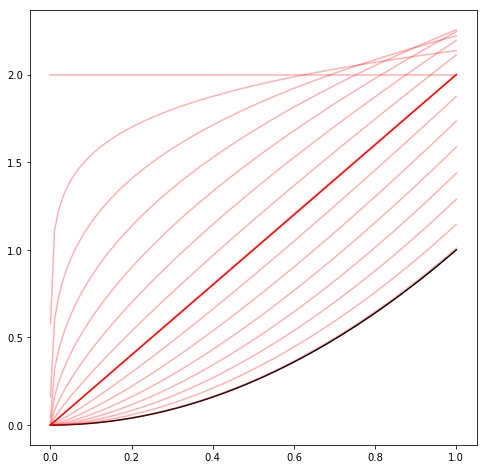

In [235]:
coeffs = np.array([0.,0.,1.])
coeffs[-1] = 1.
P = np.polynomial.polynomial.Polynomial(coeffs)
dP = P.deriv(m=1)
x = np.linspace(.0001,1,101)

plt.figure(figsize=(8,8))
plt.plot(x,P(x),color='k')
plt.plot(x,dP(x),color='r')
for a in np.linspace(.01,2,15):
    plt.plot(x,frac_deriv_poly(P,a,x),color='red',alpha=.3)
plt.show()

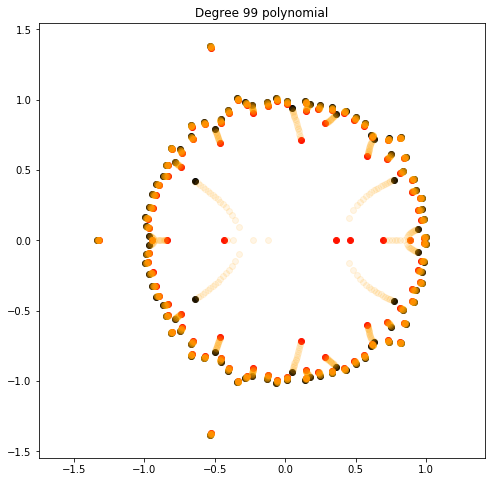

In [384]:
coeffs = np.random.randn(100)
coeffs[-1] = 1.
P = np.polynomial.polynomial.Polynomial(coeffs)
dP = P.deriv()
x = np.linspace(.1,1,101)

plt.figure(figsize=(8,8))
PR = P.roots()
dPR = dP.roots()
plt.scatter(PR.real,PR.imag,color='k')
plt.scatter(dPR.real,dPR.imag,color='r')
for a in np.linspace(.01,1,20):
    D = frac_deriv(coeffs,a)
    ew = np.linalg.eig(D)[0]
    plt.scatter(ew.real,ew.imag,color='orange',alpha=.1)
plt.title("Degree %s polynomial" % P.degree())
plt.axis('equal')
plt.show()

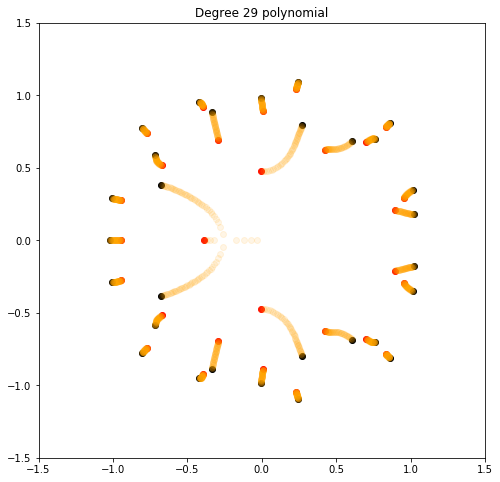

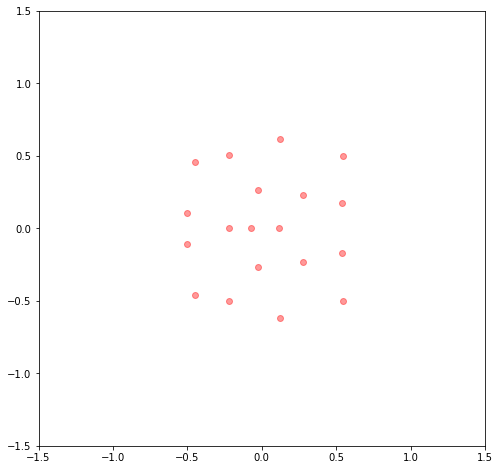

In [390]:
coeffs = np.random.randn(30)
coeffs[-1] = 1.
P = frac_deriv(coeffs,0)

plt.figure(figsize=(8,8))
R = np.linalg.eig(P)[0]
dR = np.linalg.eig(frac_deriv(coeffs,1))[0]
plt.scatter(R.real,R.imag,color='k')
plt.scatter(dR.real,dR.imag,color='r')
for a in np.linspace(.01,1,50):
    D = frac_deriv(coeffs,a)
    ew = np.linalg.eig(D)[0]
    plt.scatter(ew.real,ew.imag,color='orange',alpha=.1)
plt.title("Degree %s polynomial" % P.shape[0])
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.show()

fig = plt.figure(figsize=(8,8))
ax = plt.gca()

plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))

line, = plt.plot([], [], 'ro', alpha=.4)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    #f = lambda x: np.log(x+1)/np.log(100)
    a = np.linspace(.5,10,100)
    fD = frac_deriv(coeffs,a[i])
    f_ew = np.linalg.eig(fD)[0]
    line.set_data(f_ew.real, f_ew.imag)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)

HTML(anim.to_html5_video())

In [406]:
def frac_integ(coeffs,a):
    """
    The Matrix Fractional Antiderivative of a polynomial with given coefficients
    
    """
    n = int(np.floor(a))
    if coeffs[-1] != 1:
        coeffs /= coeffs[-1]
    k = len(coeffs[:-1]) - a # degree of polynomial
    
    # Build the companion matrix of the full polynomial
    C = np.diag(np.ones(k-1+a),-1) # companion matrix
    C[:,-1] = -coeffs[:k-1+a]
    
    # Cut the companion matrix by the integer derivative amount
    #D = C[n:,n:]
    #D[:,-1] /= G(k,a)
    #D[:,-1] *= np.array([G(i,a) for i in range(n,k)])
    return C

def test_matrix_frac_integ():
    coeffs = np.random.randn(7)
    P = np.polynomial.polynomial.Polynomial(coeffs[:-2])
    assert np.allclose(frac_integ(coeffs[:-2],0),np.polynomial.polynomial.polycompanion(P.coef))
    #assert np.allclose(frac_integ(coeffs[:-1],-1),np.polynomial.polynomial.polycompanion(P.integ(1,coeffs[-1]).coef))
    #assert np.allclose(frac_integ(coeffs,-2),np.polynomial.polynomial.polycompanion(P.integ(2,coeffs[-2:]).coef))

test_matrix_frac_integ()

ValueError: could not broadcast input array from shape (3) into shape (4)